In [5]:
import torch

from src.data.evaluation import evaluate_dwsnets, get_accuracy_st, get_accuracy_mlp
from src.model.models import DWSModelForClassification, SetTransformer, MLP
from src.data.datasets import ModelParamsDataset, ModelDataset

from tqdm import tqdm

import matplotlib.pyplot as plt

### Big zoo classification

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

splits = [[0.001, 0.001, 0.998], [0.01, 0.01, 0.98], [0.02, 0.02, 0.96], [0.05, 0.05, 0.9], [0.1, 0.1, 0.8], [0.2, 0.2, 0.6], [0.5, 0.3, 0.2], [0.7, 0.2, 0.1], [0.8, 0.1, 0.1], [0.9, 0.05, 0.05]]

# DWSNets config
normalize = True
batch_size = 512
num_workers = 4

# Set Tranformers
pos_emb = torch.tensor([0] * 30 + [1] * 110 + [2] * 110 + [3] * 11)
type_emb = torch.tensor([0] * 20 + [1] * 10 + [0] * 100 + [1] * 10 + [0] * 100 + [1] * 10 + [0] * 10 + [1] * 1)
emb = torch.stack([pos_emb, type_emb], dim=1)

dataset = ModelParamsDataset("../data/zoo_big.csv", get_as_classes=True)

accuracies_mlp = dict()
accuracies_st = dict()
accuracies_dwsnets = dict()

In [7]:
for split in tqdm(splits):
    # DWSNets
    train_dataset_size = split[0] * 10000
    val_dataset_size = split[1] * 10000
    test_dataset_size = split[2] * 10000
    splits_path = f"../data/dwsnets/splits/dataset_splits_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.json"
    statistics_path = f"../data/dwsnets/statistics/statistics_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.pth"

    test_datasetset = ModelDataset(path=splits_path, split="test", normalize=normalize, statistics_path=statistics_path)
    test_dataloader = torch.utils.data.DataLoader(dataset=test_datasetset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    point = test_datasetset.__getitem__(0)
    weight_shapes = tuple(w.shape[:2] for w in point.weights)
    bias_shapes = tuple(b.shape[:1] for b in point.biases)

    model = DWSModelForClassification( weight_shapes=weight_shapes, bias_shapes=bias_shapes, input_features=1, hidden_dim=32, n_hidden=4, n_classes=8, bn=True).to(device).eval()
    model.load_state_dict(torch.load(f"../models/classifiers/dwsnets/dwsnets_{split[0]}.pth"))

    eval_data = evaluate_dwsnets(model, test_dataloader, device)
    accuracy = eval_data["avg_acc"]
    accuracies_dwsnets[split[0]] = accuracy.item()

    # Set Transformers
    torch.manual_seed(42)
    _, _, dataset_test = torch.utils.data.random_split(dataset, split)
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    model = SetTransformer(3, 8, 1).to(device).eval()
    model.load_state_dict(torch.load(f"../models/classifiers/set_transformers/set-transformer_{split[0]}.pth"))

    accuracy = get_accuracy_st(model, dataloader_test, emb)
    accuracies_st[split[0]] = accuracy

    # MLP
    model = MLP(261, [400, 200], 8, 0.2, True, "softmax").to(device)
    model.load_state_dict(torch.load(f"../models/classifiers/mlp/big/mlp_{split[0]}.pth"))
    
    accuracy = get_accuracy_mlp(model, dataloader_test, device)
    accuracies_mlp[split[0]] = accuracy


100%|██████████| 10/10 [08:03<00:00, 48.39s/it]


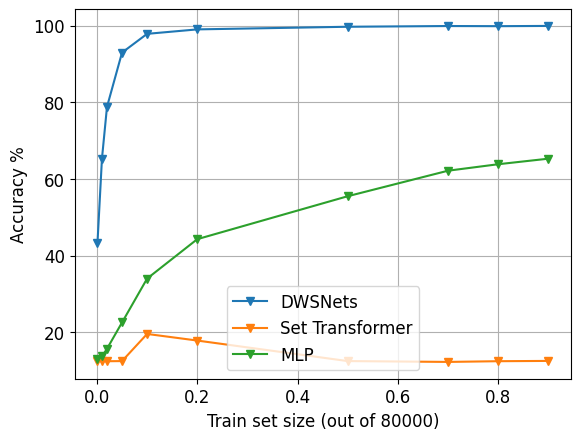

In [8]:
plt.rcParams.update({"font.size": 12})
x = list(accuracies_dwsnets.keys())
y_dwsnets = list(accuracies_dwsnets.values())
y_dwsnets = [acc * 100 for acc in y_dwsnets]
y_st = list(accuracies_st.values())
y_mlp = list(accuracies_mlp.values())

plt.plot(x, y_dwsnets, label="DWSNets", marker="v")
plt.plot(x, y_st, label="Set Transformer", marker="v")
plt.plot(x, y_mlp, label="MLP", marker="v")

plt.xlabel("Train set size (out of 80000)")
plt.ylabel("Accuracy %")
plt.legend()
plt.grid()
plt.savefig("../reports/classifiers-accuracy.pdf")
plt.show()